### Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Rainfall Prediction using Machine Learning dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

![image](./data/roc-auc.png "The ROC-AUC metric")

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
train, test = pd.read_csv("data/train.csv"), pd.read_csv("data/test.csv")

train.shape, test.shape

((2190, 13), (730, 12))

In [4]:
print("Train Data Sample")
display(train.sample(5))

print("\nTest Data Sample")
display(test.sample(5))

Train Data Sample


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
1893  1893   69    1022.7     17.3         15.7     12.3      11.8      78.0   
1481  1481   22    1021.8     21.8         18.4     16.5      14.0      72.0   
2073  2073  249    1011.5     30.5         27.4     25.5      23.8      76.0   
179    179  180    1006.8     31.2         29.0     26.1      25.4      80.0   
1351  1351  257    1013.7     31.0         28.1     26.8      24.9      81.0   

      cloud  sunshine  winddirection  windspeed  rainfall  
1893   40.0       9.1           20.0       38.3         0  
1481   40.0      10.0           40.0       14.6         0  
2073   53.0      10.1           50.0       28.6         1  
179    88.0       1.2          190.0       26.4         1  
1351   84.0       1.0          210.0       50.6         1


Test Data Sample


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
112  2302  113    1010.5     28.4         26.8     24.8      23.1      75.0   
96   2286   97    1009.5     28.6         26.8     25.8      23.3      89.0   
487  2677  123    1006.7     29.2         26.7     24.5      24.8      87.0   
253  2443  254    1008.2     31.0         28.8     26.4      23.3      74.0   
275  2465  276    1011.0     27.6         24.8     23.7      21.0      89.0   

     cloud  sunshine  winddirection  windspeed  
112   81.0       3.3           80.0       11.9  
96    88.0       0.3          220.0       30.3  
487   82.0       2.2           50.0       24.4  
253   65.0       8.1           10.0       14.6  
275   88.0       1.2           50.0       40.4

In [5]:
print("Train Data Info")
display(train.info())

print("\nTest Data Info")
display(test.info())

Train Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


None


Test Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


None

In [6]:
print(f"Train Data Null Values: {train.isnull().sum().sum()}")
print(f"\nTest Data Null Values: {test.isnull().sum().sum()}")

test.winddirection = test.winddirection.fillna(test.winddirection.mean())

Train Data Null Values: 0

Test Data Null Values: 1


In [7]:
print("Train Data Descriptive Statistics")
train.describe(include="all").T.style.background_gradient(cmap='Pastel2')

Train Data Descriptive Statistics


In [8]:
print("Test Data Descriptive Statistics")
test.describe(include="all").T.style.background_gradient(cmap='Pastel1')

Test Data Descriptive Statistics


In [9]:
NUM_COLS = train.select_dtypes(exclude="object").columns.tolist()
CAT_COLS = train.select_dtypes(include="object").columns.tolist()

print(f'Numerical Features: {NUM_COLS[2:-1]}')
print(f'Categorical Features: {CAT_COLS}')

print(f'\nTarget Feature: {NUM_COLS[-1:]}')

Numerical Features: ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
Categorical Features: []

Target Feature: ['rainfall']


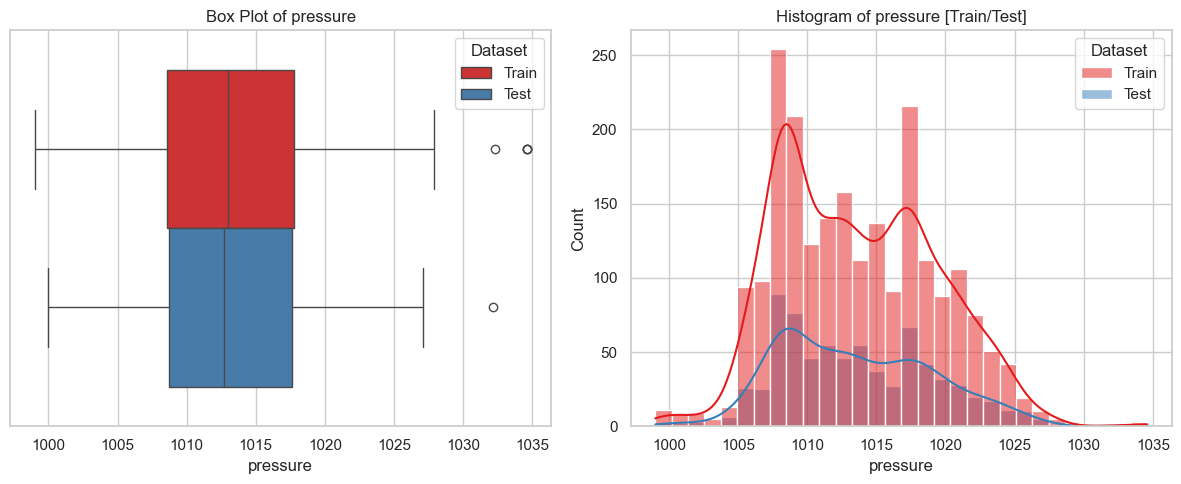

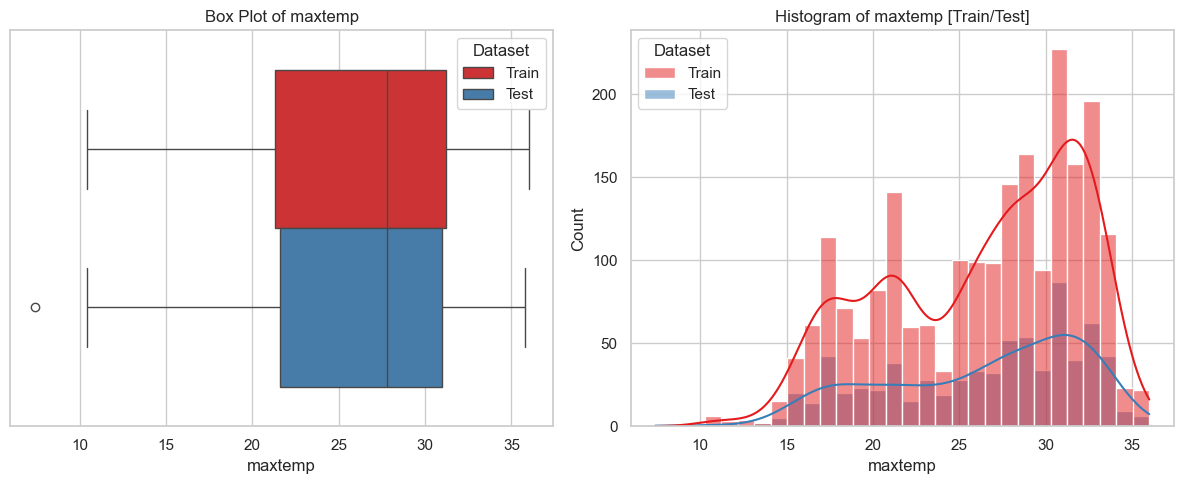

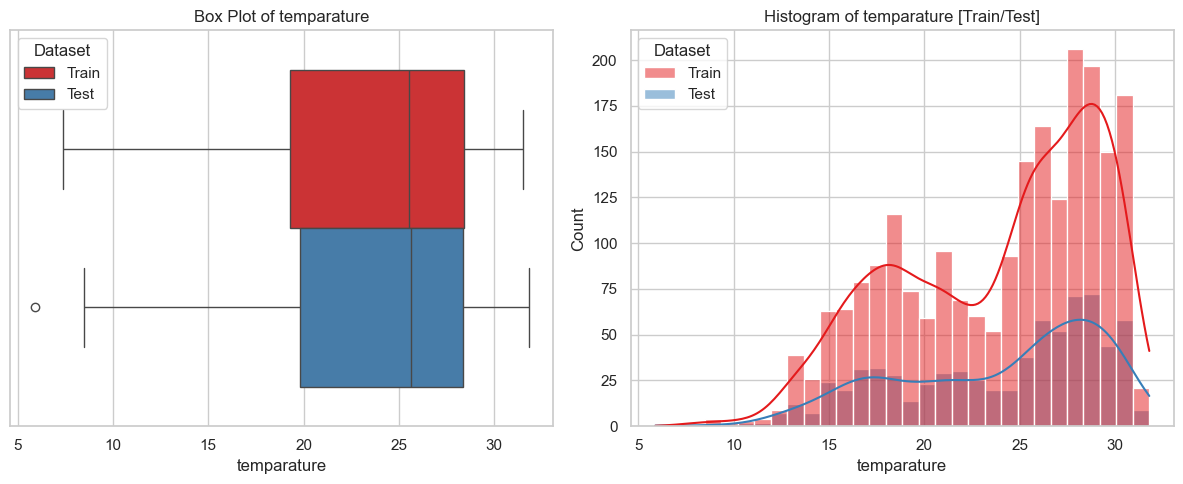

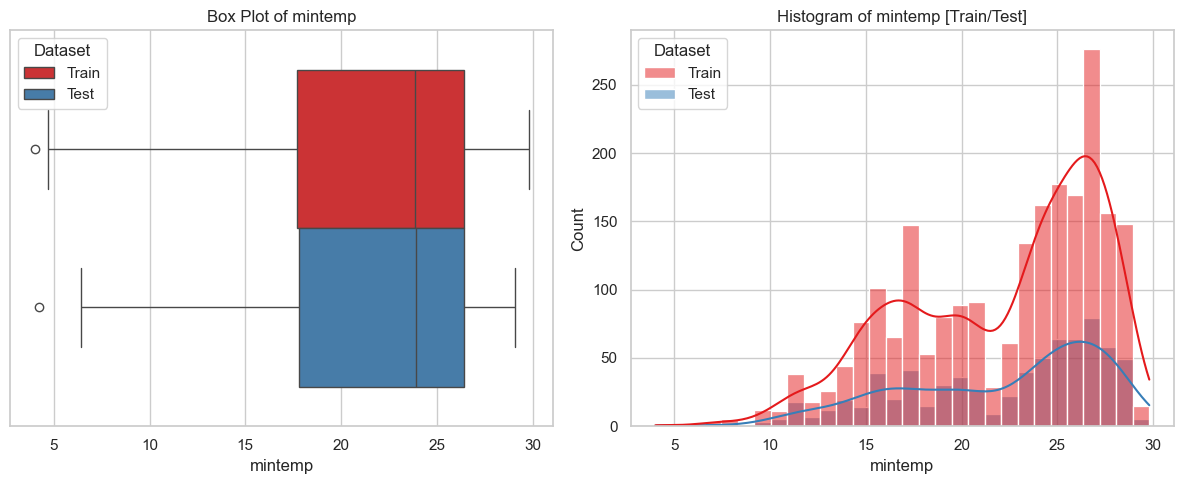

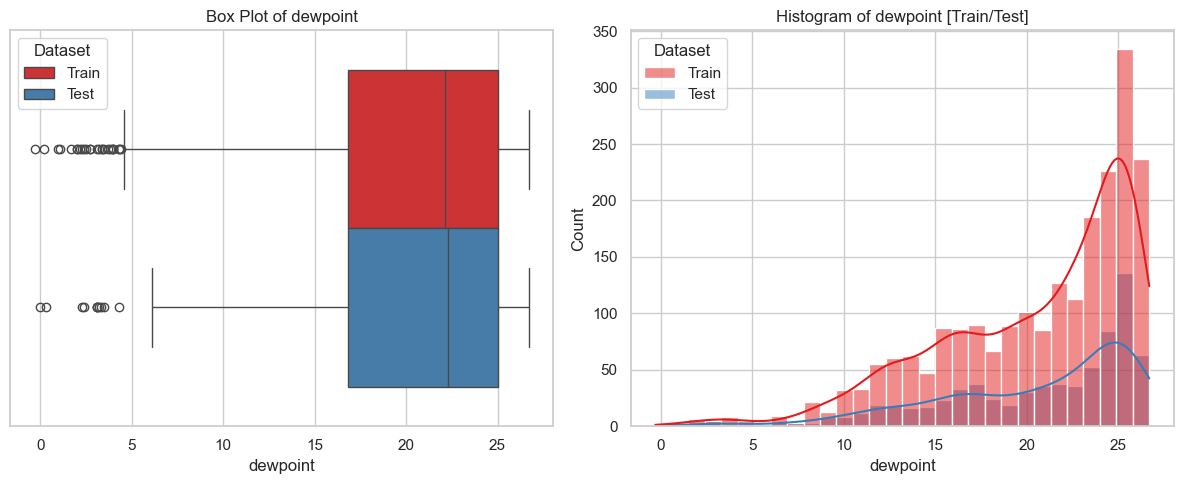

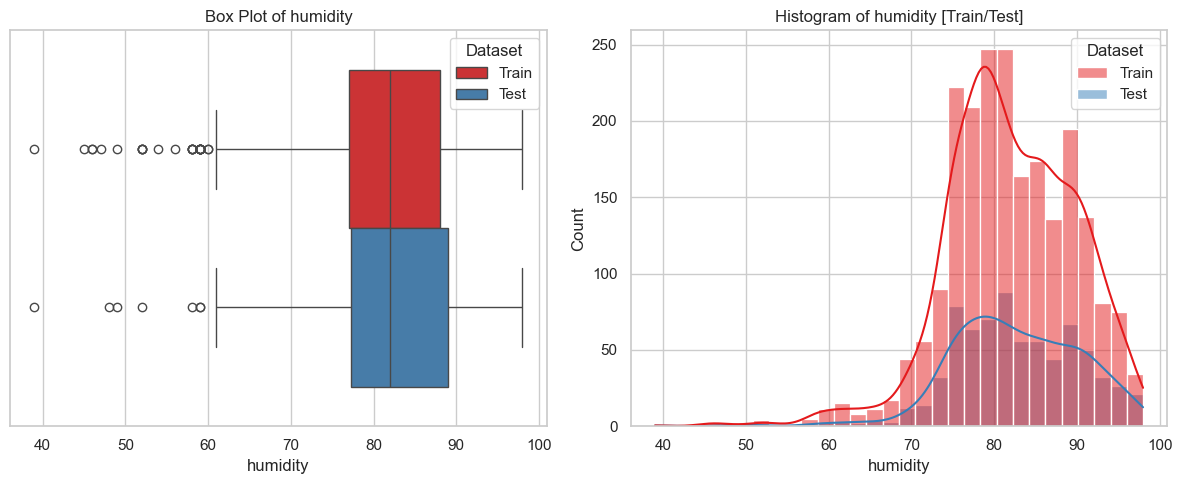

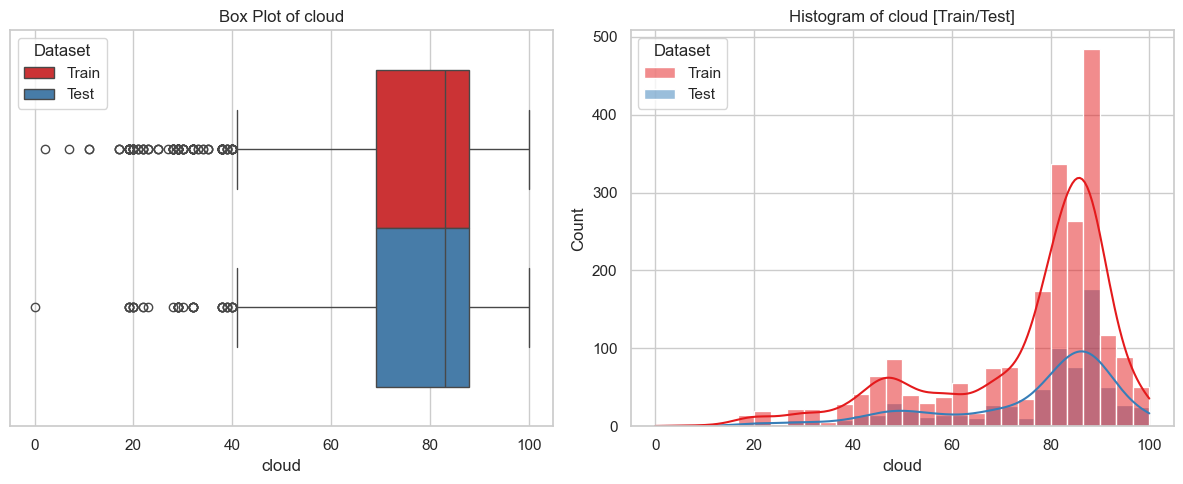

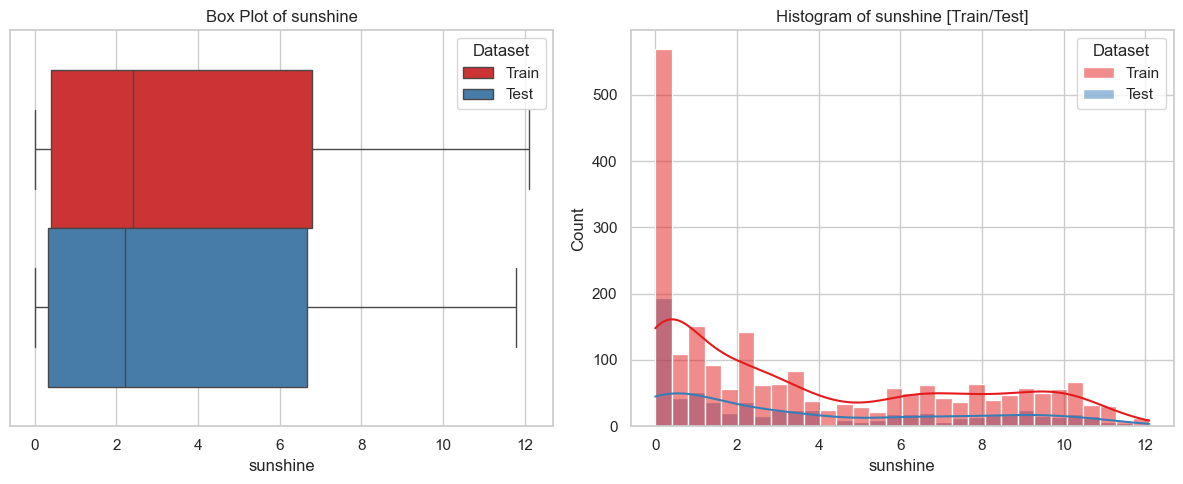

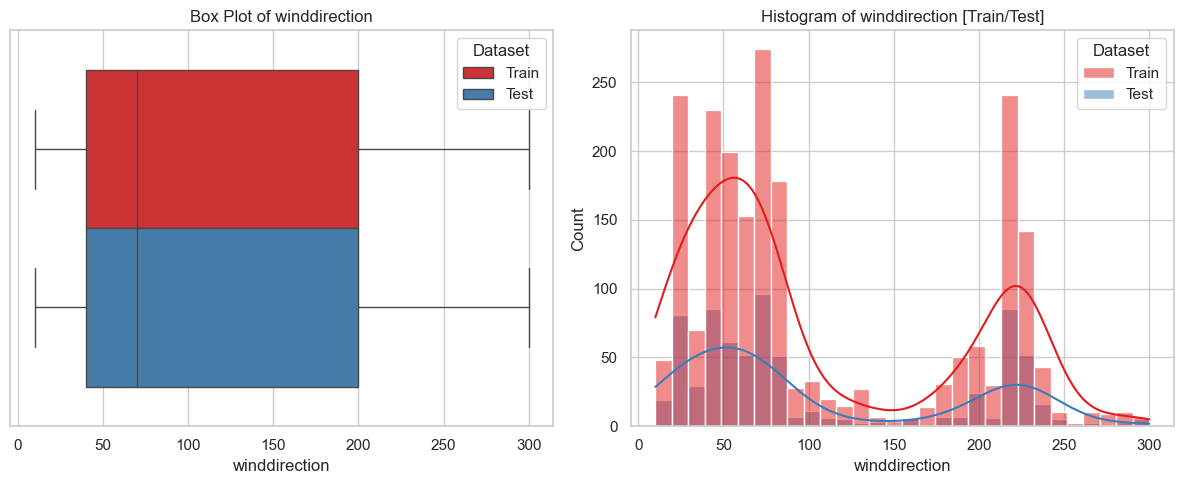

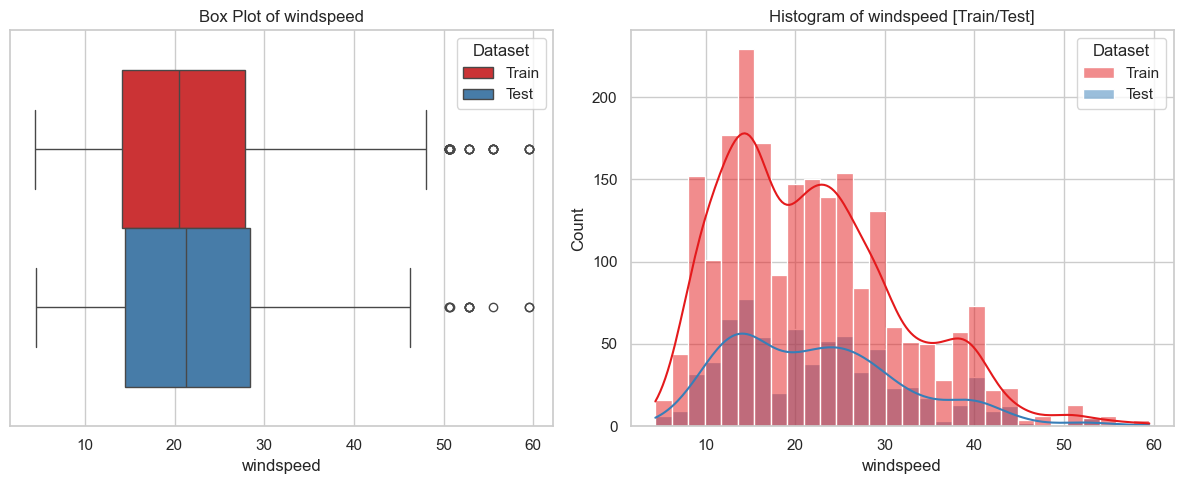

In [10]:
FEATURES = NUM_COLS[2:-1]
TARGET = NUM_COLS[-1]

train_temp, test_temp = train.copy(), test.copy()
train_temp["Dataset"], test_temp["Dataset"] = "Train", "Test"
combined = pd.concat([train_temp, test_temp])

def create_var_plots(var):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax = ax.flatten()

    sns.boxplot(data=combined, x=var, hue="Dataset", palette="Set1", ax=ax[0])
    ax[0].set_title(f"Box Plot of {var}")
    ax[0].set_xlabel(var)

    sns.histplot(data=combined, x=var, kde=True, bins=30, hue="Dataset", palette="Set1", ax=ax[1])
    ax[1].set_title(f"Histogram of {var} [Train/Test]")
    ax[1].set_xlabel(var)

    plt.tight_layout()
    plt.show()


for var in FEATURES:
    create_var_plots(var)

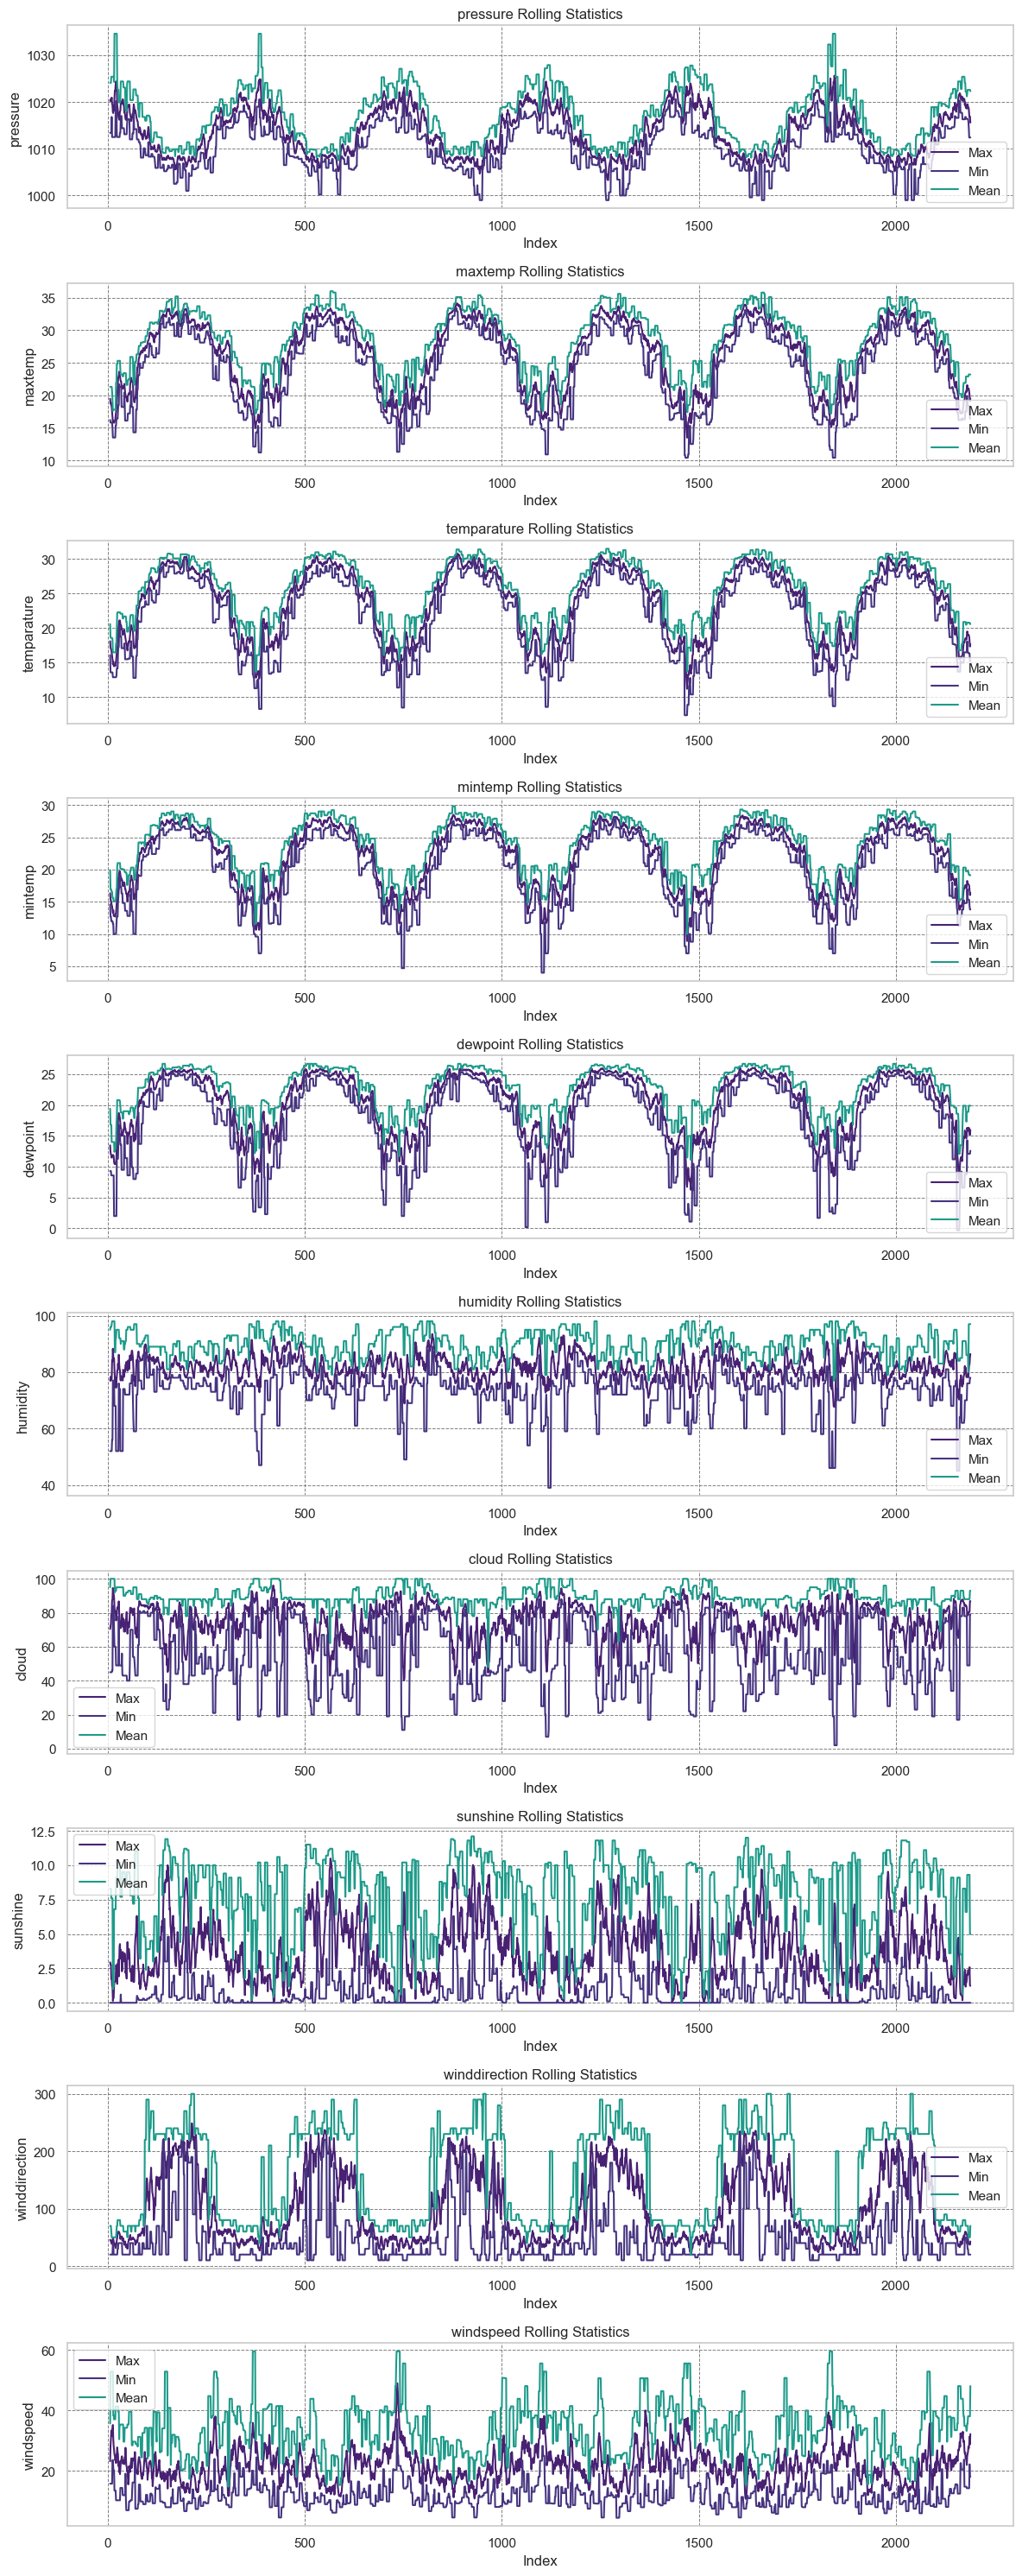

In [11]:
# colors = [(0.232815, 0.732247, 0.459277, 1.0), (0.265145, 0.232956, 0.516599, 1.0), (0.15627, 0.489624, 0.557936, 1.0)]
colors = [plt.get_cmap("viridis")(i) for i in np.random.random(3)]

fig, ax = plt.subplots(len(FEATURES), 1, figsize=(12, len(FEATURES) * 3))
ax = ax.flatten()

for i, var in enumerate(FEATURES):
    roll_mean = train[var].rolling(window=7).mean()
    roll_min = train[var].rolling(window=7).min()
    roll_max = train[var].rolling(window=7).max()

    ax[i].plot(roll_mean, label='Max', color=colors[0])
    ax[i].plot(roll_min, label='Min', color=colors[1])
    ax[i].plot(roll_max, label='Mean', color=colors[2])

    ax[i].set_title(f'{var} Rolling Statistics')
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(var)
    ax[i].grid(color='gray', linestyle='--', linewidth=0.7)
    ax[i].legend()

plt.tight_layout()
plt.show()

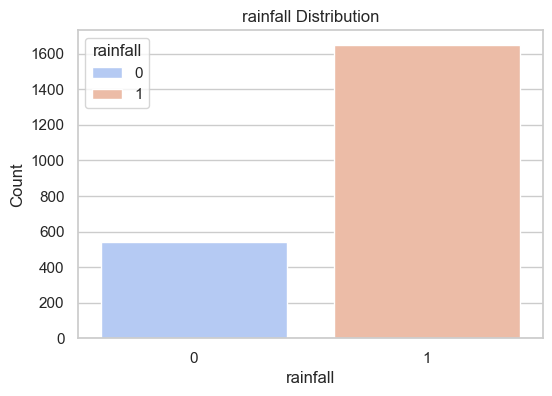

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x=TARGET, hue=TARGET, palette="coolwarm")
plt.title(f'{TARGET} Distribution')
plt.xlabel(TARGET)
plt.ylabel('Count')
plt.show()


The most important things in raining are sunshine and cloud!

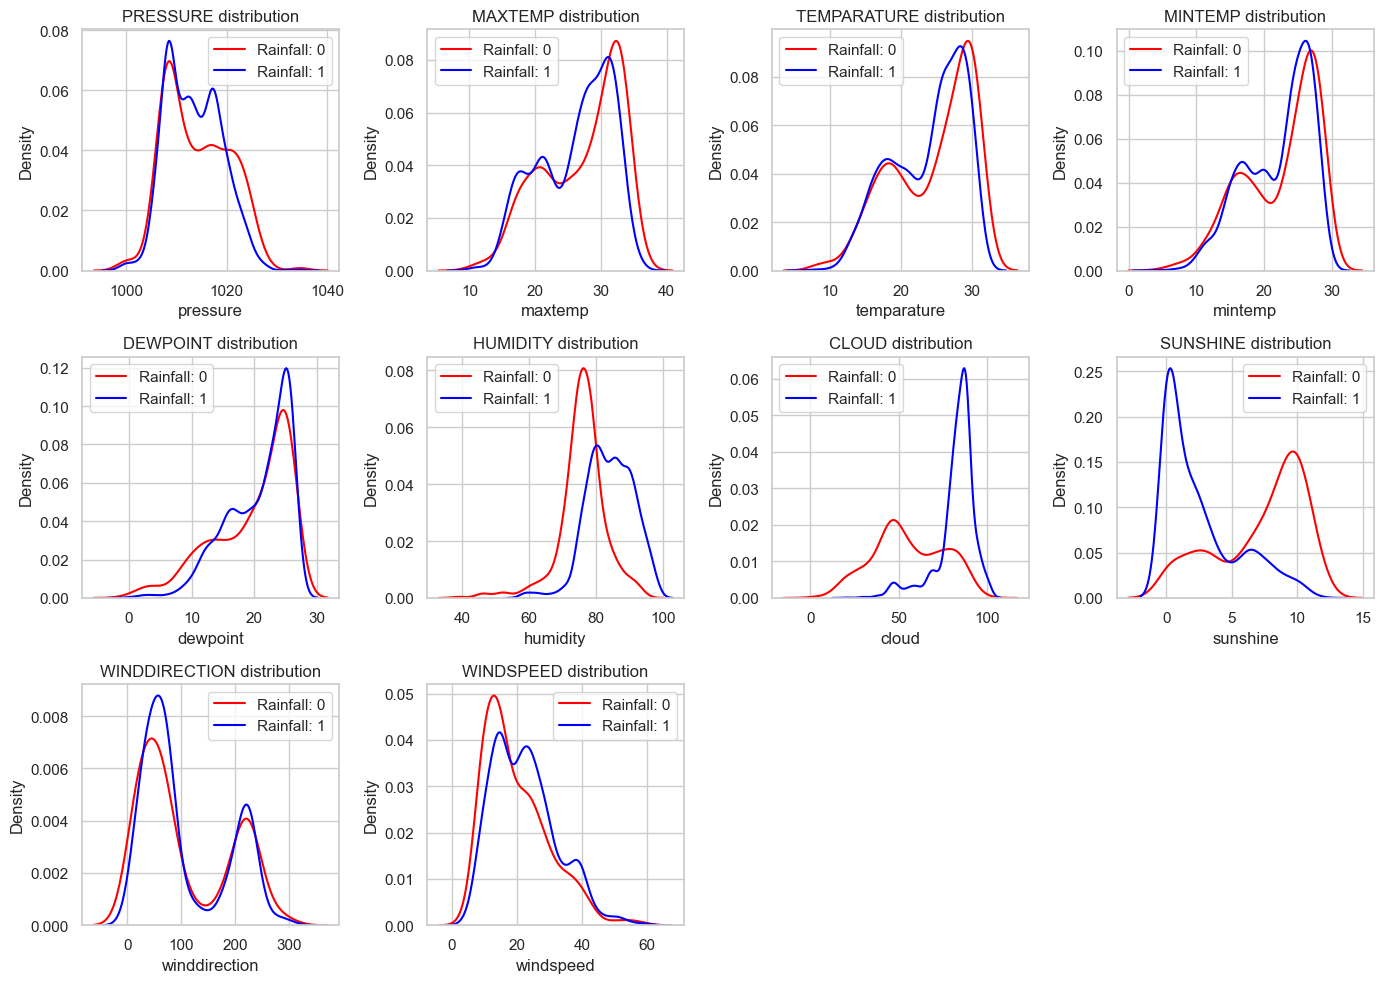

In [13]:
# KDE Plot for Feature-Target Relationship
plt.figure(figsize=(14, 10))

for i, col in enumerate(FEATURES, start=1):
    plt.subplot(3, 4, i)
    sns.kdeplot(train[col][train[TARGET] == 0], label='Rainfall: 0', color='red')
    sns.kdeplot(train[col][train[TARGET] == 1], label='Rainfall: 1', color='blue')
    plt.title(f'{col.upper()} distribution')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

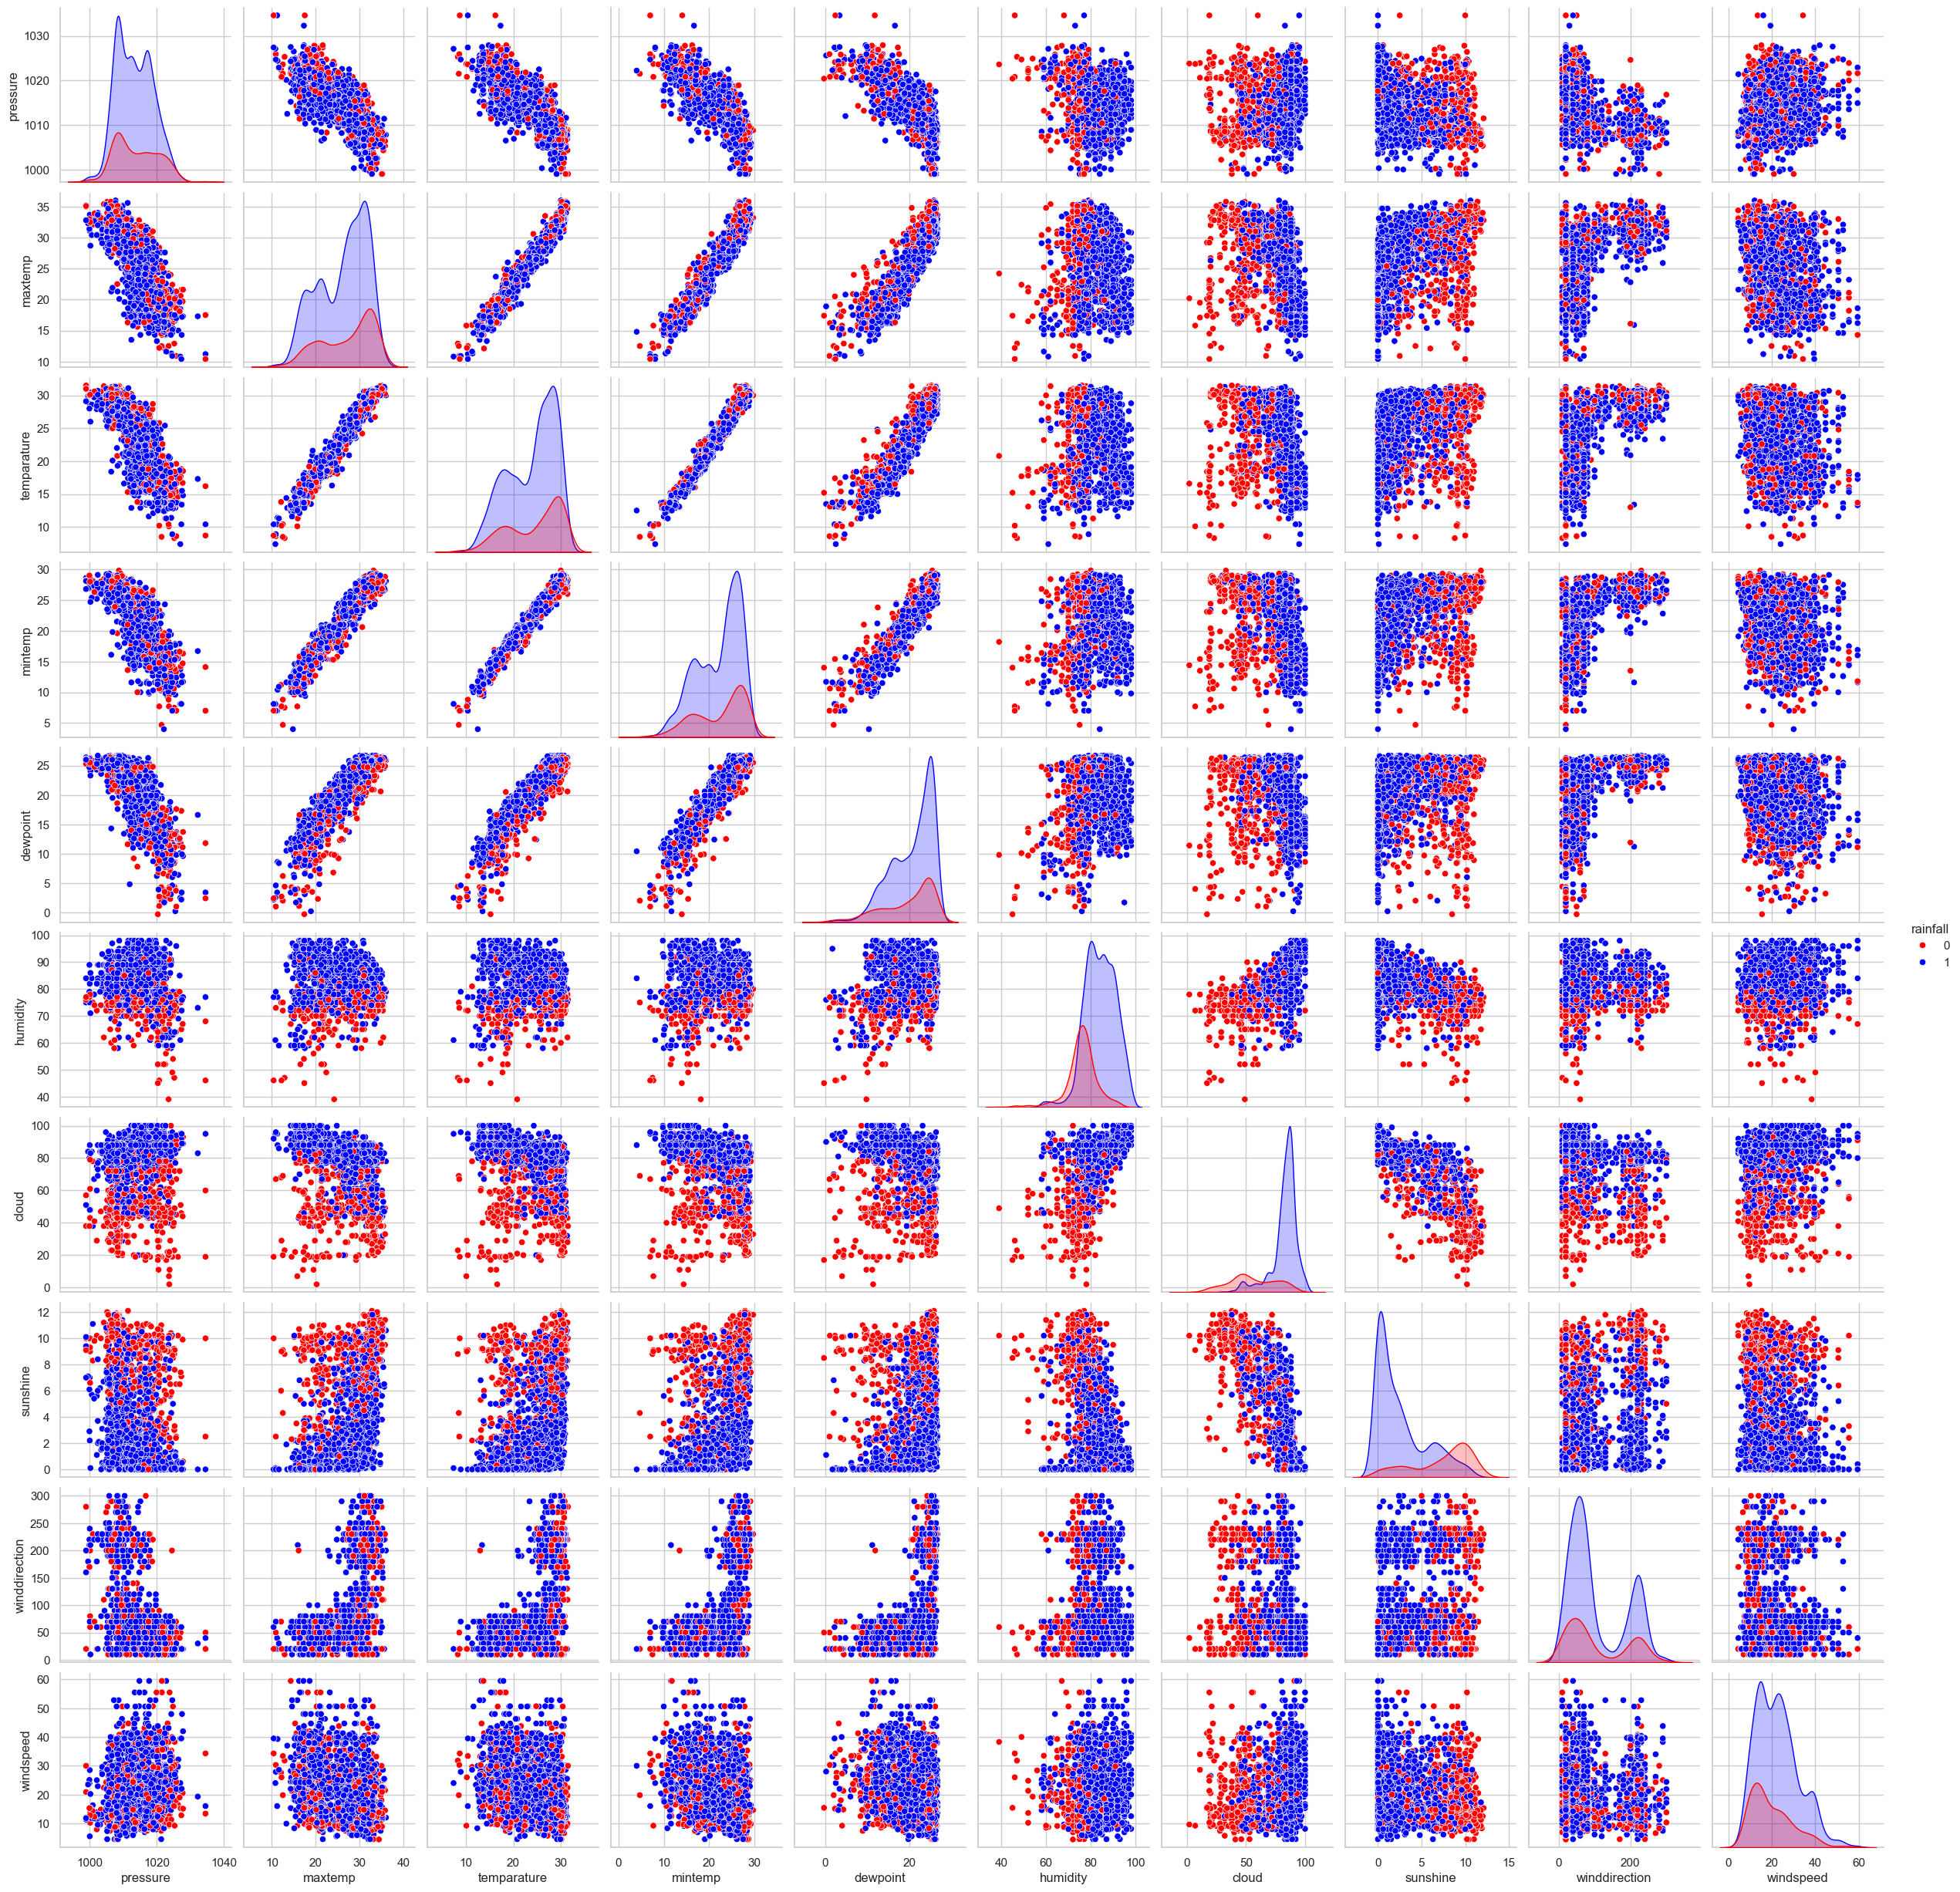

In [14]:
# Pair Plot Analysis
sns.pairplot(train[FEATURES + [TARGET]], hue=TARGET, palette=['red', 'blue'])
plt.show()


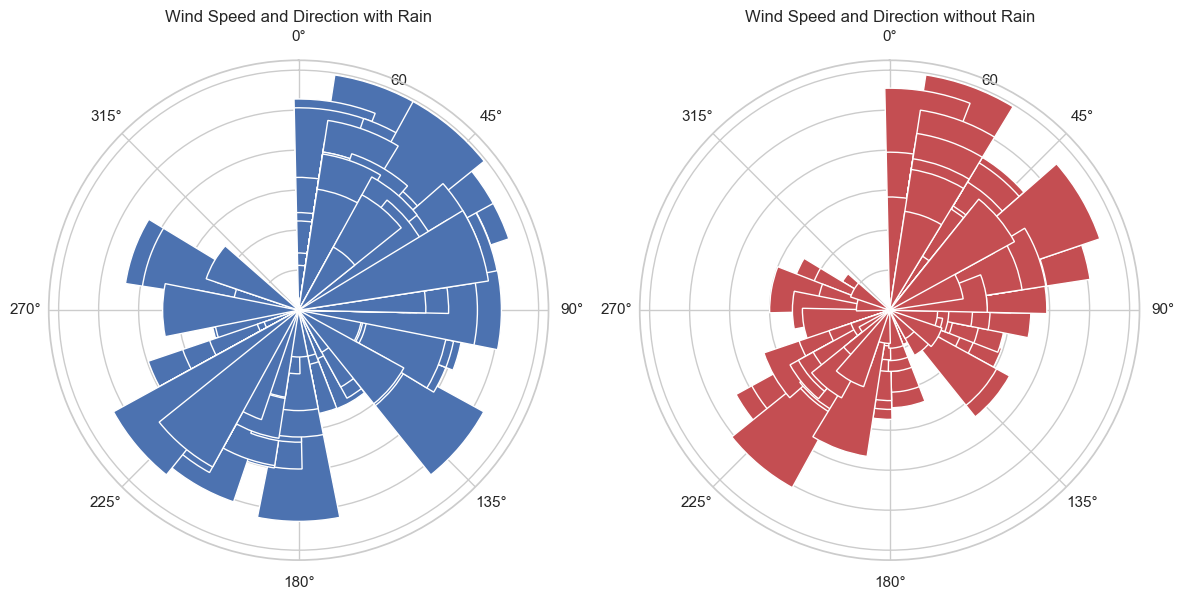

In [15]:
rain_data, no_rain_data = train[train[TARGET] == 1], train[train[TARGET] == 0]

fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

# First wind rose plot
ax[0].set_theta_direction(-1)
ax[0].set_theta_offset(np.pi / 2)
bars1 = ax[0].bar(
    np.deg2rad(rain_data['winddirection']),
    rain_data['windspeed'],
    width=np.pi/8,
    bottom=0.0,
    color="b"  
)
ax[0].set_title('Wind Speed and Direction with Rain')

# Second wind rose plot (no rain)
ax[1].set_theta_direction(-1)
ax[1].set_theta_offset(np.pi / 2.0)
bars2 = ax[1].bar(
    np.deg2rad(no_rain_data['winddirection']),
    no_rain_data['windspeed'],
    width=np.pi/8,
    bottom=0.0,
    color="r"  
)
ax[1].set_title('Wind Speed and Direction without Rain')

plt.tight_layout()
plt.show()

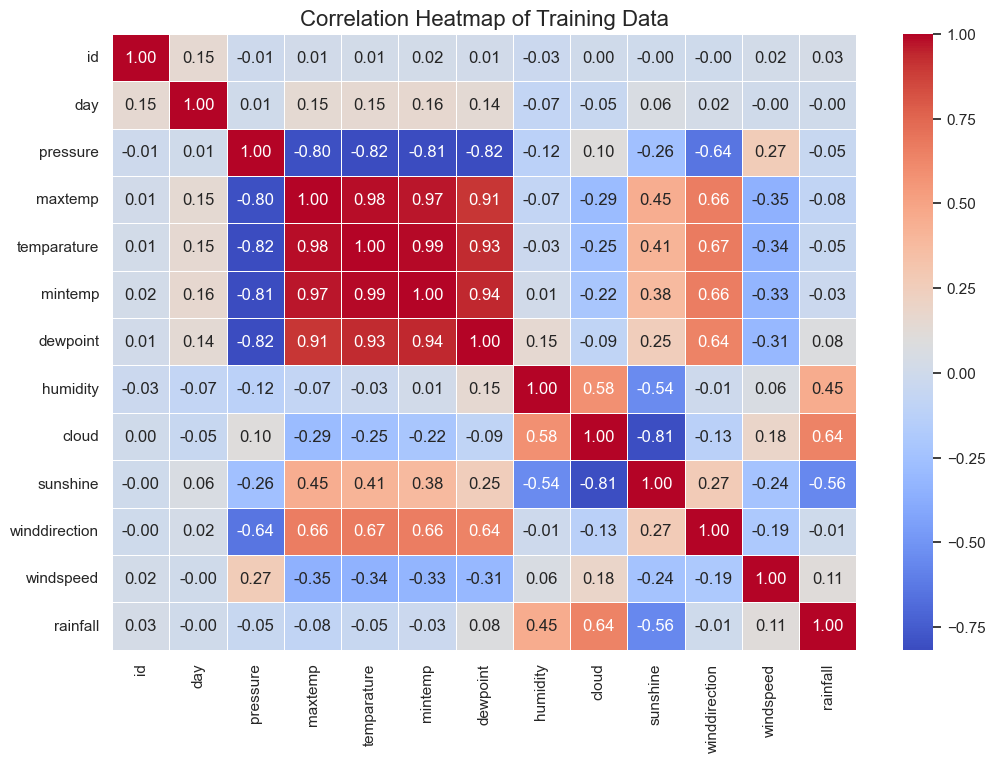

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, annot_kws={'size': 12}, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Training Data', fontsize=16)
plt.show()


## Feature Engineering

In [17]:
def preprocess_weather_data(data):
    # Feature Engineering
    data["dew_humidity"] = data["dewpoint"] * data["humidity"] # ***
    data["cloud_windspeed"] = data["cloud"] * data["windspeed"] # ***
    data["cloud_to_humidity"] = data["cloud"] / data["humidity"]
    data["temp_to_sunshine"] = data["sunshine"] / data["temparature"] # ***

    
    #data["temp_range"] = data["maxtemp"] - data["mintemp"]
    #data["temp_from_dewpoint"] = data["temparature"] - data["dewpoint"] # **?
    #data["wind_speeddirection"] = data["windspeed"] * data["winddirection"]
    #data['avg_temp'] = (data['maxtemp'] + data['mintemp']) / 2
    #data['cloud_persistence'] = data['cloud'] * data['sunshine']  # If both are low, it means the cloud cover persists.
    #data['pressure_temp_ratio'] = data['pressure'] / (data['temparature'] + 1)  # Avoid division by zero.
    #data['dew_temp_diff'] = data['temparature'] - data['dewpoint']
    #data['dew_humidity_ratio'] = data['dewpoint'] / (data['humidity'] + 1)
    #data['cloud_humidity_plus'] = data['cloud'] + data["humidity"] 
    #data['cloud_humidity_sunshine_plus'] = data['cloud'] + data["humidity"] + data['sunshine']
    #data['cloud_sunshine_*'] = data['cloud'] * data['sunshine']
    data['wind_temp_interaction'] = data['windspeed'] * data['temparature']
    #data['sunshine_wind_interaction'] = data['sunshine'] + data['windspeed'] # *
    #data['cloud_humidity_ratio'] = data['cloud'] + (data['humidity'])  # Avoid division by zero
    #data['pressure_temp_ratio'] = data['pressure'] / (data['temparature'] + 1)  # Avoid division by zero
    #data['cloud_wind_ratio'] = data['cloud'] / (data['windspeed'] + 1)  # Avoid division by zero


    #data['cloud_coverage_rate'] = data['cloud'] / 100  # Normalize to 0-1 range 
    #data['cloud_sun_interaction'] = data['cloud'] * (1 - data['sunshine'])

    
    #data['weather_severity'] = (data['cloud'] * data['humidity']) / (data['pressure'] * (data['sunshine'] + 1))
    data['cloud_sun_ratio'] = data['cloud'] / (data['sunshine'] + 1) # ***
    #data["cloud_sunshine_+"] = data["cloud"] + data["sunshine"]
    #data["cloud_sunshine_-"] = data["cloud"] - data["sunshine"]
    data["dew_humidity/sun"] = data["dewpoint"] * data["humidity"] / (data['sunshine'] + 1)
    data["dew_humidity_+"] = data["dewpoint"] * data["humidity"]
    

    data['humidity_sunshine_*'] = data["humidity"] * data['sunshine']

    data["cloud_humidity/pressure"] = (data["cloud"] * data["humidity"]) / data["pressure"]
    

    # Extract temporal features
    data['month'] = ((data['day'] - 1) // 30 + 1).clip(upper=12)
    data['season'] = data['month'].apply(lambda x: 1 if 3 <= x <= 5  # Spring
                                         else 2 if 6 <= x <= 8  # Summer
                                         else 3 if 9 <= x <= 11  # Autumn
                                         else 0)  # Winter
    # Seasonal trends
    #data['season_temp_trend'] = data['temparature'] * data['season']
    data['season_cloud_trend'] = data['cloud'] * data['season']
    

    # Seasonal deviation from mean values
    data['season_cloud_deviation'] = data['cloud'] - data.groupby('season')['cloud'].transform('mean')
    data['season_temperature'] = data['temparature'] * data['season']  # Interaction of temper



    
    data = data.drop(columns=["month"])
    #data['season_temp_trend'] = data['avg_temp'] * data['season']
    #data['season_dewpoint_trend'] = data['dewpoint'] * data['season']
    #data["dew_humidity_with_season"] = data['humidity'] * data['season']
    
    data = data.drop(columns=["maxtemp", "winddirection", "humidity", "temparature", "pressure", "day", "season"])

    return data

# Apply to train and test datasets
train_processed = preprocess_weather_data(train)
test_processed = preprocess_weather_data(test)

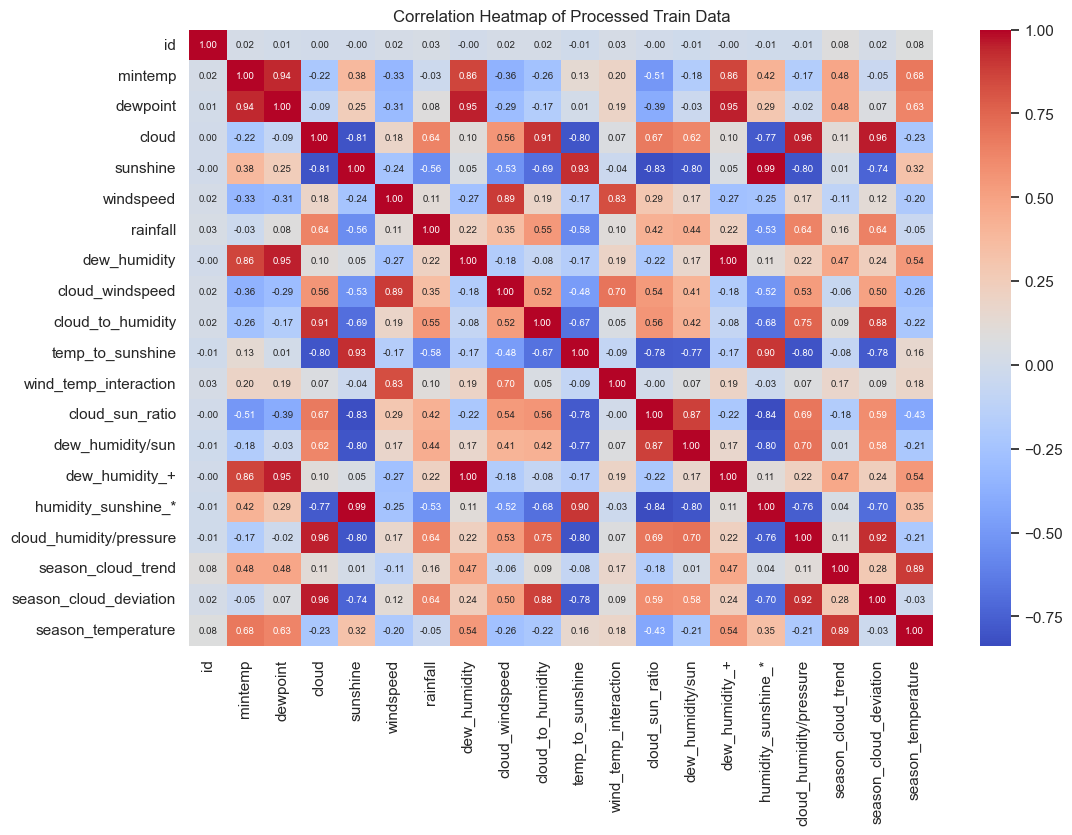

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(train_processed.corr(), annot=True, annot_kws={"size": 7}, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Processed Train Data')
plt.show()

In [19]:
train_processed.columns

Index(['id', 'mintemp', 'dewpoint', 'cloud', 'sunshine', 'windspeed',
       'rainfall', 'dew_humidity', 'cloud_windspeed', 'cloud_to_humidity',
       'temp_to_sunshine', 'wind_temp_interaction', 'cloud_sun_ratio',
       'dew_humidity/sun', 'dew_humidity_+', 'humidity_sunshine_*',
       'cloud_humidity/pressure', 'season_cloud_trend',
       'season_cloud_deviation', 'season_temperature'],
      dtype='object')

In [20]:
X = train_processed.drop(columns=["id", "rainfall"])
y = train_processed[TARGET]

X_test = test_processed.drop(columns=["id"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [21]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    'XGBoost Classifier': XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42),
    'CatBoost Classifier': CatBoostClassifier(iterations=100, learning_rate=0.14, depth=6, verbose=0, random_state=42)
}


# Train models using StratifiedKFold cross-validation
FOLDS = 13
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
auc_scores, roc_curves = {}, {}


for name, model in models.items():
    print(f"\n### {name} ###")
    oof_preds = np.zeros(len(y))

    for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"FOLD {i + 1}", end=", ")
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]


        if hasattr(model, 'fit'):
            if "eval_set" in model.fit.__code__.co_varnames:
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)
            else:
                model.fit(X_train, y_train)
        
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y, oof_preds)
    auc_scores[name] = auc_score
    fpr, tpr, _ = roc_curve(y, oof_preds)
    roc_curves[name] = (fpr, tpr, auc_score)

print("\n\n")
# Print the AUC scores for each model
for model, score in auc_scores.items():
    print(f"{model}: {score:.4f}")



### Logistic Regression ###
FOLD 1, FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 
### Random Forest Classifier ###
FOLD 1, FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 
### Gradient Boosting Classifier ###
FOLD 1, FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 
### Support Vector Machine ###
FOLD 1, FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 
### K-Nearest Neighbors ###
FOLD 1, 

c:\Users\yashs\miniconda3\envs\learn\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\yashs\miniconda3\envs\learn\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\yashs\miniconda3\envs\learn\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yashs\miniconda3\envs\learn\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\yashs\miniconda3\envs\learn\Lib\subprocess.py", line 1538

FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 
### Neural Network ###
FOLD 1, FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 
### XGBoost Classifier ###
FOLD 1, FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 
### CatBoost Classifier ###
FOLD 1, FOLD 2, FOLD 3, FOLD 4, FOLD 5, FOLD 6, FOLD 7, FOLD 8, FOLD 9, FOLD 10, FOLD 11, FOLD 12, FOLD 13, 


Logistic Regression: 0.8937
Random Forest Classifier: 0.8794
Gradient Boosting Classifier: 0.8895
Support Vector Machine: 0.8504
K-Nearest Neighbors: 0.8537
Neural Network: 0.8834
XGBoost Classifier: 0.8863
CatBoost Classifier: 0.8985


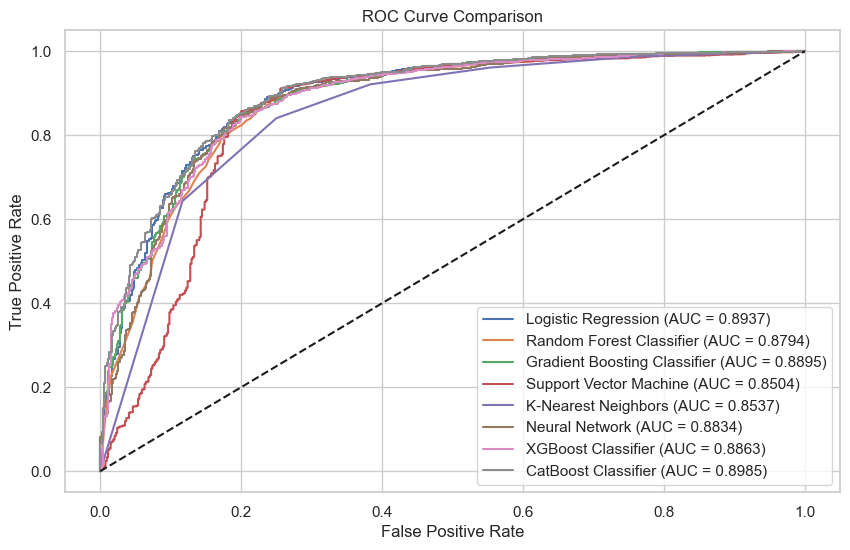

In [22]:
# Plot ROC curves for each model
plt.figure(figsize=(10, 6))
for name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

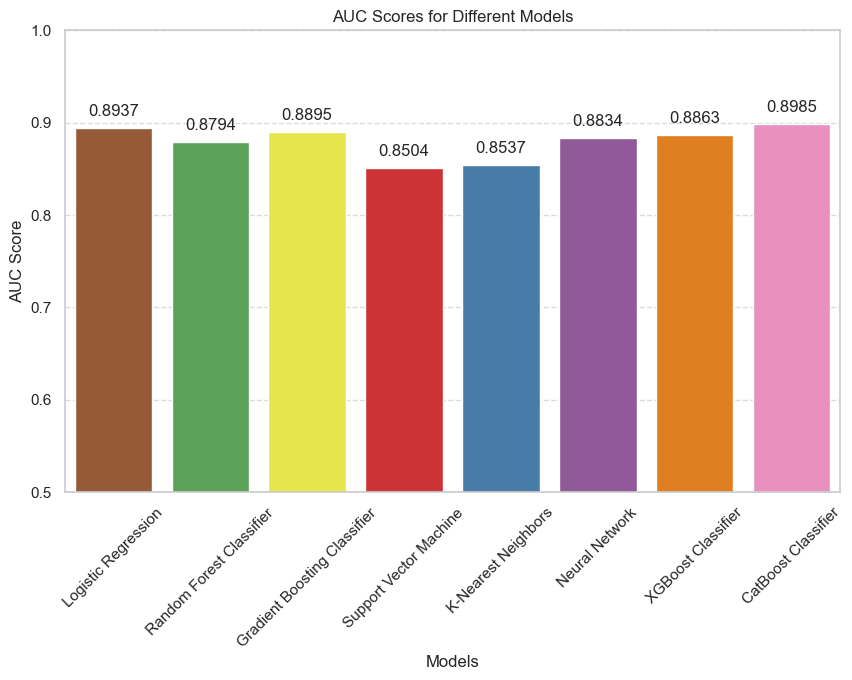

In [23]:
# Plot AUC Score
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(auc_scores.keys()), y=list(auc_scores.values()), hue=list(auc_scores.values()), palette='Set1', legend=False)

# Annotate the bars with their values
for i, score in enumerate(auc_scores.values()):
    ax.text(i, score + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Models')
plt.ylim(0.5, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [24]:
# Find the best model overall
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = models[best_model_name]
print(f"The best model is {best_model_name.upper()} with an AUC score of {auc_scores[best_model_name]:.4f}.")

The best model is CATBOOST CLASSIFIER with an AUC score of 0.8985.


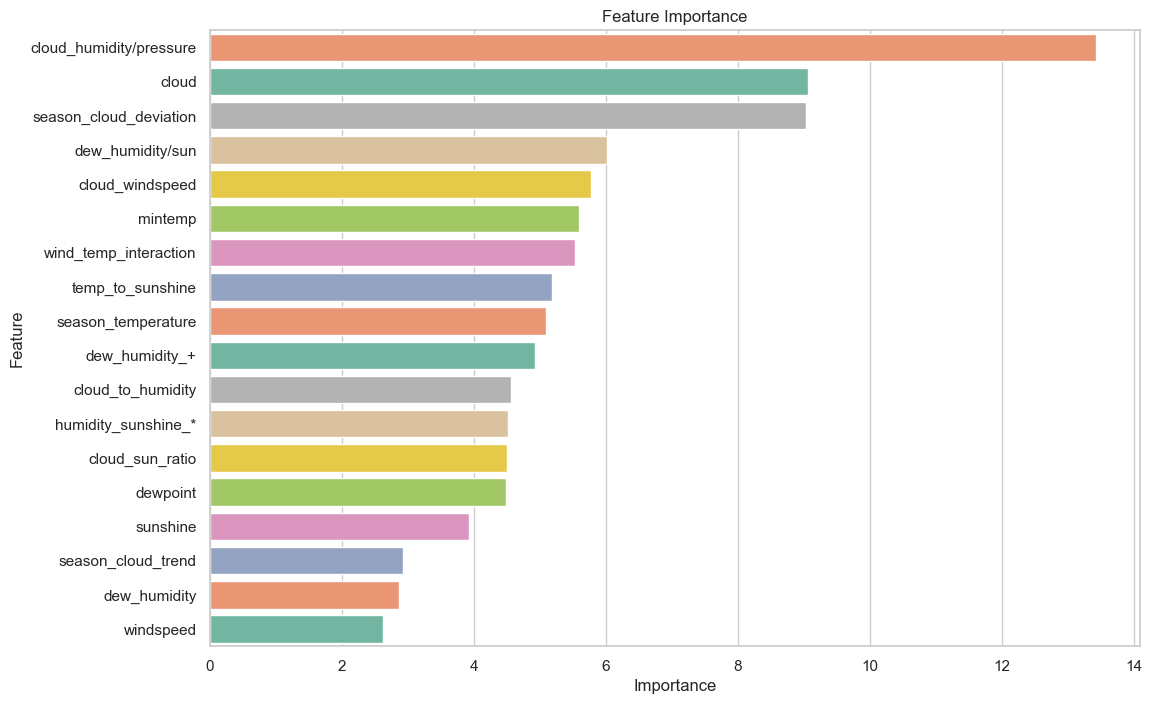

In [25]:
# Visualize Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    importance_type = 'Feature Importance'
else:
    feature_importance = np.abs(best_model.coef_[0])
    importance_type = 'Coefficient Magnitude'


feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df, hue='Importance', palette='Set2', legend=False)

plt.title(f'{importance_type}')
plt.show()

In [26]:
# Train the model on the top N features
top_n = [*range(8, 20)]

best_auc_top = best_top_n = 0
best_oof_preds_top = None

for n in top_n:
    # print(f'Running model with top {n} features...')
    top_features = feature_df['Feature'][:n].tolist()
    X_train_top = X_scaled[:, X.columns.isin(top_features)]
    X_test_top = X_test_scaled[:, X.columns.isin(top_features)]

    best_model.fit(X_train_top, y)

    oof_preds_top = np.zeros(len(y))
    for i, (train_idx, val_idx) in enumerate(skf.split(X_train_top, y)):
        # print(f"FOLD {i + 1}", end=", ")
        X_train_fold, X_val_fold = X_train_top[train_idx], X_train_top[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        best_model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=100, verbose=False)
        oof_preds_top[val_idx] = best_model.predict_proba(X_val_fold)[:, 1]
    
    auc_top_score = roc_auc_score(y, oof_preds_top)
    print(f"AUC Score for top {n} features: {auc_top_score:.4f}")

    if auc_top_score > best_auc_top:
        best_auc_top = auc_top_score
        best_top_n = n
        best_oof_preds_top = oof_preds_top


AUC Score for top 8 features: 0.8985
AUC Score for top 9 features: 0.8998
AUC Score for top 10 features: 0.8976
AUC Score for top 11 features: 0.8969
AUC Score for top 12 features: 0.8978
AUC Score for top 13 features: 0.8972
AUC Score for top 14 features: 0.8992
AUC Score for top 15 features: 0.8984
AUC Score for top 16 features: 0.8990
AUC Score for top 17 features: 0.8959
AUC Score for top 18 features: 0.8985
AUC Score for top 19 features: 0.8985


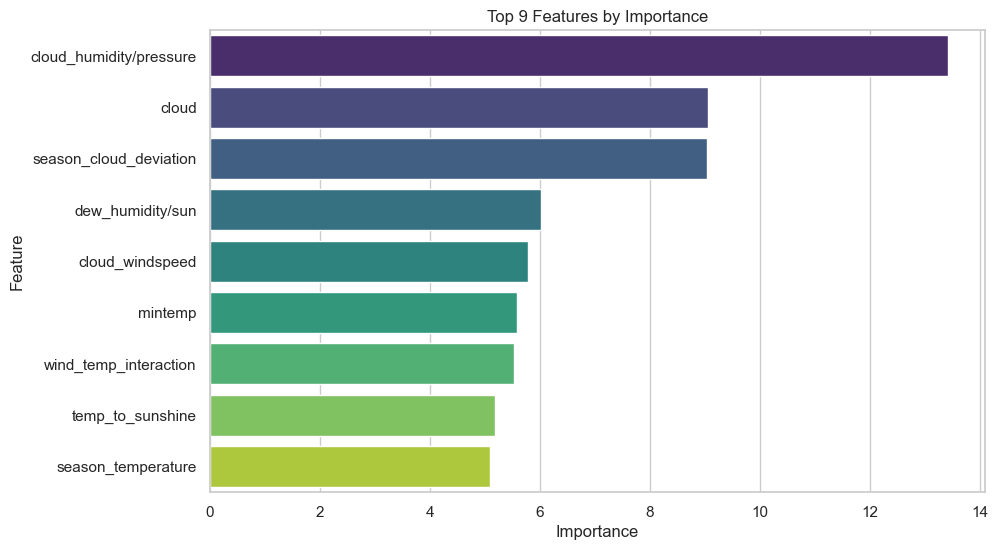

In [27]:
best_features = feature_df[:best_top_n]

plt.figure(figsize=(10, 6))
sns.barplot(data=best_features, x='Importance', y='Feature', palette='viridis', hue='Feature')
plt.title(f'Top {best_top_n} Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()